## Anomaly Detection using AutoEncoders
AutoEncoders are widely used in anomaly detection. The reconstruction errors are used as the anomaly scores. Let us look at how we can use AutoEncoder for anomaly detection using TensorFlow.

Import the required libraries and load the data. Here we are using the ECG data which consists of labels 0 and 1. Label 0 denotes the observation as an anomaly and label 1 denotes the observation as normal.
https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head(200)

# data shape
# (4998, 141)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [15]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
print(x_train_scaled.shape,x_test_scaled.shape)
print(y_train[5])

(3998, 140) (1000, 140) (3998,) (1000,)
(2335, 140) (1000, 140)
1.0


## The last column in the data is the target ( column name is 140). Split the data for training and testing and scale the data using MinMaxScaler.

In [10]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

2022-02-17 16:00:57.905484: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 16:00:57.907671: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


Train on 2335 samples, validate on 1000 samples
Epoch 1/20


2335/2335 [==============================] - 2s 671us/sample - loss: 0.0110 - mse: 0.0250 - val_loss: 0.0134 - val_mse: 0.0316
Epoch 2/20
2335/2335 [==============================] - 0s 69us/sample - loss: 0.0106 - mse: 0.0242 - val_loss: 0.0131 - val_mse: 0.0308
Epoch 3/20
2335/2335 [==============================] - 0s 63us/sample - loss: 0.0099 - mse: 0.0227 - val_loss: 0.0127 - val_mse: 0.0297
Epoch 4/20
2335/2335 [==============================] - 0s 62us/sample - loss: 0.0090 - mse: 0.0204 - val_loss: 0.0124 - val_mse: 0.0290
Epoch 5/20
2335/2335 [==============================] - 0s 62us/sample - loss: 0.0080 - mse: 0.0182 - val_loss: 0.0119 - val_mse: 0.0278
Epoch 6/20
2335/2335 [==============================] - 0s 63us/sample - loss: 0.0071 - mse: 0.0161 - val_loss: 0.0114 - val_mse: 0.0265
Epoch 7/20
2335/2335 [==============================] - 0s 61us/sample - loss: 0.0064 - mse: 0.0144 - val_loss: 0.0111 - val_mse: 0.0259
Epoch 8/20
2335/2335 [=============================

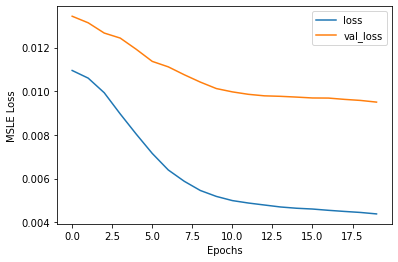

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [14]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, x_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
print(type(predictions))
accuracy_score(predictions, y_test)
# 0.944

Threshold: 0.009345181746650862
<class 'pandas.core.series.Series'>


0.942